In [1]:
import pickle
import torch
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys, os
sys.path.append("../..")

from models.classic import Modular
from utils.evaluation import evaluate_list
from model_train import load_win10_data
from sklearn.metrics import f1_score, recall_score, precision_score


def set_seed(seed_value=1763):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def draw_confusion_matrix(y_true, y_pred, counts=False, figsize=(6,6)):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)

    f, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")


def print_scores(y_true, y_pred):
    print("F1: ",f1_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", (y_true == y_pred).numpy().mean() * 100)

## 100 epochs, with Batch Norm in FFNN

In [2]:
set_seed(0)

device="cpu"
model_path="ep100-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128-model.torch"
bytes_used="keep_bytes-ed64-pl150-kb150-1641410856.pickle"

with open(bytes_used, "rb") as f:
    keep_bytes = pickle.load(f)

model = Modular(vocab_size = len(keep_bytes) + 2,
        embedding_dim = 64,
        hidden_neurons = [256, 128],
        batch_norm_ffnn = True
        ).to(device)

model_dict = torch.load(model_path, map_location=device)
model.load_state_dict(model_dict)

X = np.load([x for x in os.listdir() if "X-" in x and "1641410856" in x][0])
y = np.load([x for x in os.listdir() if "y-" in x and "1641410856" in x][0])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_train),torch.LongTensor(y_train)),
        batch_size = 1024, shuffle=True)

model.eval()
y_pred = torch.Tensor()
y_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(train_loader):
        print(f"{batch_idx}/{len(train_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        y_pred = torch.hstack([y_pred, preds])
        y_true = torch.hstack([y_true, target])

0/304 1/304 2/304 3/304 4/304 5/304 6/304 7/304 8/304 9/304 10/304 11/304 12/304 13/304 14/304 15/304 16/304 17/304 18/304 19/304 20/304 21/304 22/304 23/304 24/304 25/304 26/304 27/304 28/304 29/304 30/304 31/304 32/304 33/304 34/304 35/304 36/304 37/304 38/304 39/304 40/304 41/304 42/304 43/304 44/304 45/304 46/304 47/304 48/304 49/304 50/304 51/304 52/304 53/304 54/304 55/304 56/304 57/304 58/304 59/304 60/304 61/304 62/304 63/304 64/304 65/304 66/304 67/304 68/304 69/304 70/304 71/304 72/304 73/304 74/304 75/304 76/304 77/304 78/304 79/304 80/304 81/304 82/304 83/304 84/304 85/304 86/304 87/304 88/304 89/304 90/304 91/304 92/304 93/304 94/304 95/304 96/304 97/304 98/304 99/304 100/304 101/304 102/304 103/304 104/304 105/304 106/304 107/304 108/304 109/304 110/304 111/304 112/304 113/304 114/304 115/304 116/304 117/304 118/304 119/304 120/304 121/304 122/304 123/304 124/304 125/304 126/304 127/304 128/304 129/304 130/304 131/304 132/304 133/304 134/304 135/304 136/304 137/304 138/30

In [3]:
val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_val),torch.LongTensor(y_val)),
        batch_size = 1024, shuffle=True)

model.eval()
yval_pred = torch.Tensor()
yval_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(val_loader):
        print(f"{batch_idx}/{len(val_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        yval_pred = torch.hstack([yval_pred, preds])
        yval_true = torch.hstack([yval_true, target])

0/76 1/76 2/76 3/76 4/76 5/76 6/76 7/76 8/76 9/76 10/76 11/76 12/76 13/76 14/76 15/76 16/76 17/76 18/76 19/76 20/76 21/76 22/76 23/76 24/76 25/76 26/76 27/76 28/76 29/76 30/76 31/76 32/76 33/76 34/76 35/76 36/76 37/76 38/76 39/76 40/76 41/76 42/76 43/76 44/76 45/76 46/76 47/76 48/76 49/76 50/76 51/76 52/76 53/76 54/76 55/76 56/76 57/76 58/76 59/76 60/76 61/76 62/76 63/76 64/76 65/76 66/76 67/76 68/76 69/76 70/76 71/76 72/76 73/76 74/76 75/76 

F1:  0.9472429683775624
Recall:  0.9614128462561994
Precision:  0.9334847120541832
Accuracy:  96.58339550798837


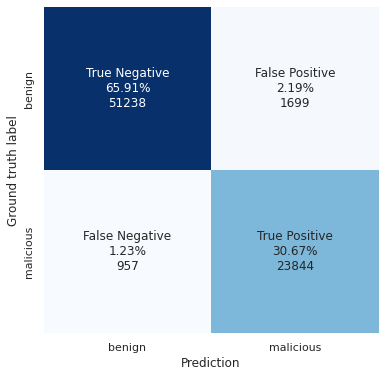

In [6]:
print_scores(yval_true, yval_pred)
draw_confusion_matrix(yval_true, yval_pred, counts=True)

F1:  0.9887464894584868
Recall:  0.9966805889213409
Precision:  0.9809377115443103
Accuracy:  99.2680495256472


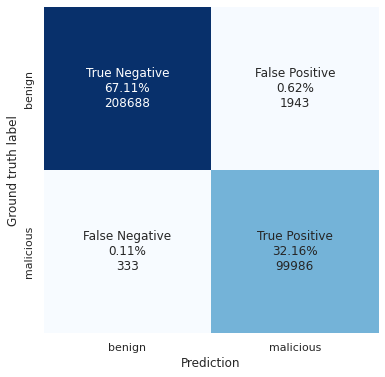

In [7]:
print_scores(y_true, y_pred)
draw_confusion_matrix(y_true, y_pred, counts=True)

## 50 epochs, without Batch Norm on FFNN

Noticeable overfitting ...

In [3]:
set_seed(0)

device="cpu"
model_path="ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128-model.torch"
bytes_used="keep_bytes-ed64-pl150-kb150-1641463139.pickle"

with open(bytes_used, "rb") as f:
    keep_bytes = pickle.load(f)

model = Modular(vocab_size = len(keep_bytes) + 2,
        embedding_dim = 64,
        hidden_neurons = [256, 128],
        batch_norm_ffnn = False
        ).to(device)

model_dict = torch.load(model_path, map_location=device)
model.load_state_dict(model_dict)


X = np.load([x for x in os.listdir() if "X-" in x and "1641463139" in x][0])
y = np.load([x for x in os.listdir() if "y-" in x and "1641463139" in x][0])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_train),torch.LongTensor(y_train)),
        batch_size = 1024, shuffle=True)

model.eval()
y_pred = torch.Tensor()
y_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(train_loader):
        print(f"{batch_idx}/{len(train_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        y_pred = torch.hstack([y_pred, preds])
        y_true = torch.hstack([y_true, target])

val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_val),torch.LongTensor(y_val)),
        batch_size = 1024, shuffle=True)

model.eval()
yval_pred = torch.Tensor()
yval_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(val_loader):
        print(f"{batch_idx}/{len(val_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        yval_pred = torch.hstack([yval_pred, preds])
        yval_true = torch.hstack([yval_true, target])

0/304 1/304 2/304 3/304 4/304 5/304 6/304 7/304 8/304 9/304 10/304 11/304 12/304 13/304 14/304 15/304 16/304 17/304 18/304 19/304 20/304 21/304 22/304 23/304 24/304 25/304 26/304 27/304 28/304 29/304 30/304 31/304 32/304 33/304 34/304 35/304 36/304 37/304 38/304 39/304 40/304 41/304 42/304 43/304 44/304 45/304 46/304 47/304 48/304 49/304 50/304 51/304 52/304 53/304 54/304 55/304 56/304 57/304 58/304 59/304 60/304 61/304 62/304 63/304 64/304 65/304 66/304 67/304 68/304 69/304 70/304 71/304 72/304 73/304 74/304 75/304 76/304 77/304 78/304 79/304 80/304 81/304 82/304 83/304 84/304 85/304 86/304 87/304 88/304 89/304 90/304 91/304 92/304 93/304 94/304 95/304 96/304 97/304 98/304 99/304 100/304 101/304 102/304 103/304 104/304 105/304 106/304 107/304 108/304 109/304 110/304 111/304 112/304 113/304 114/304 115/304 116/304 117/304 118/304 119/304 120/304 121/304 122/304 123/304 124/304 125/304 126/304 127/304 128/304 129/304 130/304 131/304 132/304 133/304 134/304 135/304 136/304 137/304 138/30

F1:  0.9812625122040216
Recall:  0.9918460112241948
Precision:  0.9709024911448728
Accuracy:  98.77793857533365


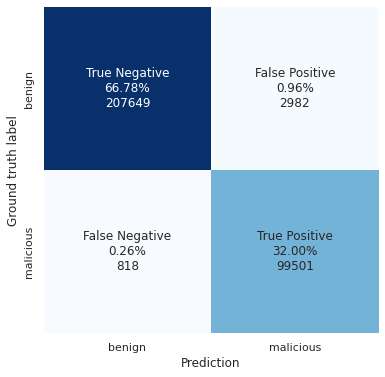

In [4]:
print_scores(y_true, y_pred)
draw_confusion_matrix(y_true, y_pred, counts=True)

F1:  0.9408813478973672
Recall:  0.9603241804765937
Precision:  0.9222101757918377
Accuracy:  96.14988808562093


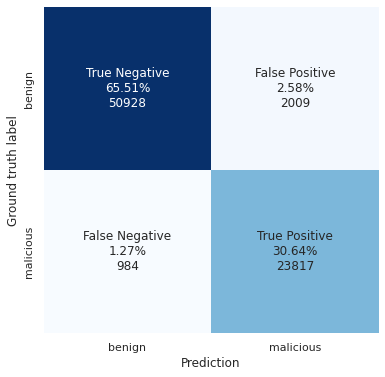

In [5]:
print_scores(yval_true, yval_pred)
draw_confusion_matrix(yval_true, yval_pred, counts=True)

# 50 epochs with Weight Decay $\lambda=0.001$ and AdamW 

0/304 1/304 2/304 3/304 4/304 5/304 6/304 7/304 8/304 9/304 10/304 11/304 12/304 13/304 14/304 15/304 16/304 17/304 18/304 19/304 20/304 21/304 22/304 23/304 24/304 25/304 26/304 27/304 28/304 29/304 30/304 31/304 32/304 33/304 34/304 35/304 36/304 37/304 38/304 39/304 40/304 41/304 42/304 43/304 44/304 45/304 46/304 47/304 48/304 49/304 50/304 51/304 52/304 53/304 54/304 55/304 56/304 57/304 58/304 59/304 60/304 61/304 62/304 63/304 64/304 65/304 66/304 67/304 68/304 69/304 70/304 71/304 72/304 73/304 74/304 75/304 76/304 77/304 78/304 79/304 80/304 81/304 82/304 83/304 84/304 85/304 86/304 87/304 88/304 89/304 90/304 91/304 92/304 93/304 94/304 95/304 96/304 97/304 98/304 99/304 100/304 101/304 102/304 103/304 104/304 105/304 106/304 107/304 108/304 109/304 110/304 111/304 112/304 113/304 114/304 115/304 116/304 117/304 118/304 119/304 120/304 121/304 122/304 123/304 124/304 125/304 126/304 127/304 128/304 129/304 130/304 131/304 132/304 133/304 134/304 135/304 136/304 137/304 138/30

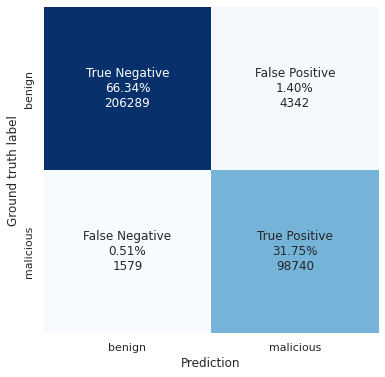

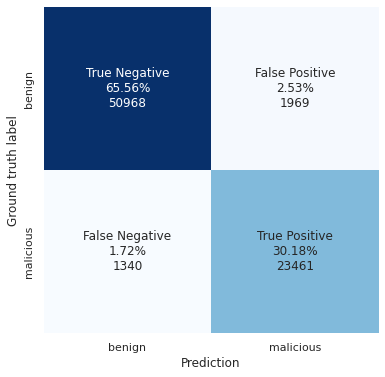

In [6]:
set_seed(0)

device="cpu"
model_path="ep49-optim_adamw-lr0.001-l2reg0.1-dr0.0_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128-model.torch"
bytes_used="keep_bytes-ed64-pl150-kb150-1641463139.pickle"

with open(bytes_used, "rb") as f:
    keep_bytes = pickle.load(f)

model = Modular(vocab_size = len(keep_bytes) + 2,
        embedding_dim = 64,
        hidden_neurons = [256, 128],
        batch_norm_ffnn = True,
        dropout=0
        ).to(device)

model_dict = torch.load(model_path, map_location=device)
model.load_state_dict(model_dict)


X = np.load([x for x in os.listdir() if "X-" in x and "1641463139" in x][0])
y = np.load([x for x in os.listdir() if "y-" in x and "1641463139" in x][0])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_train),torch.LongTensor(y_train)),
        batch_size = 1024, shuffle=True)

model.eval()
y_pred = torch.Tensor()
y_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(train_loader):
        print(f"{batch_idx}/{len(train_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        y_pred = torch.hstack([y_pred, preds])
        y_true = torch.hstack([y_true, target])

val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_val),torch.LongTensor(y_val)),
        batch_size = 1024, shuffle=True)

model.eval()
yval_pred = torch.Tensor()
yval_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(val_loader):
        print(f"{batch_idx}/{len(val_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        yval_pred = torch.hstack([yval_pred, preds])
        yval_true = torch.hstack([yval_true, target])


print("\nTraining set")
print_scores(y_true, y_pred)
draw_confusion_matrix(y_true, y_pred, counts=True)
print("\nValidation set")
print_scores(yval_true, yval_pred)
draw_confusion_matrix(yval_true, yval_pred, counts=True)

# 50 epochs with WD $\lambda = 0.1$ and AdamW

In [4]:
set_seed(0)

device="cpu"
model_path="ep49-optim_adamw-lr0.001-l2reg0.1-dr0.0_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128-model.torch"
bytes_used="keep_bytes-ed64-pl150-kb150-1641463139.pickle"

with open(bytes_used, "rb") as f:
    keep_bytes = pickle.load(f)

model = Modular(vocab_size = len(keep_bytes) + 2,
        embedding_dim = 64,
        hidden_neurons = [256, 128],
        batch_norm_ffnn = True,
        dropout=0
        ).to(device)

model_dict = torch.load(model_path, map_location=device)
model.load_state_dict(model_dict)


X = np.load([x for x in os.listdir() if "X-" in x and "1641463139" in x][0])
y = np.load([x for x in os.listdir() if "y-" in x and "1641463139" in x][0])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_train),torch.LongTensor(y_train)),
        batch_size = 1024, shuffle=True)

model.eval()
y_pred = torch.Tensor()
y_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(train_loader):
        print(f"{batch_idx}/{len(train_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        y_pred = torch.hstack([y_pred, preds])
        y_true = torch.hstack([y_true, target])

val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.LongTensor(X_val),torch.LongTensor(y_val)),
        batch_size = 1024, shuffle=True)

model.eval()
yval_pred = torch.Tensor()
yval_true = torch.Tensor()
for batch_idx, (data, target) in enumerate(val_loader):
        print(f"{batch_idx}/{len(val_loader)}", end=" ")
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            logits = model(data)
        
        preds = torch.argmax(logits, dim=1).flatten()
        yval_pred = torch.hstack([yval_pred, preds])
        yval_true = torch.hstack([yval_true, target])

0/304 1/304 2/304 3/304 4/304 5/304 6/304 7/304 8/304 9/304 10/304 11/304 12/304 13/304 14/304 15/304 16/304 17/304 18/304 19/304 20/304 21/304 22/304 23/304 24/304 25/304 26/304 27/304 28/304 29/304 30/304 31/304 32/304 33/304 34/304 35/304 36/304 37/304 38/304 39/304 40/304 41/304 42/304 43/304 44/304 45/304 46/304 47/304 48/304 49/304 50/304 51/304 52/304 53/304 54/304 55/304 56/304 57/304 58/304 59/304 60/304 61/304 62/304 63/304 64/304 65/304 66/304 67/304 68/304 69/304 70/304 71/304 72/304 73/304 74/304 75/304 76/304 77/304 78/304 79/304 80/304 81/304 82/304 83/304 84/304 85/304 86/304 87/304 88/304 89/304 90/304 91/304 92/304 93/304 94/304 95/304 96/304 97/304 98/304 99/304 100/304 101/304 102/304 103/304 104/304 105/304 106/304 107/304 108/304 109/304 110/304 111/304 112/304 113/304 114/304 115/304 116/304 117/304 118/304 119/304 120/304 121/304 122/304 123/304 124/304 125/304 126/304 127/304 128/304 129/304 130/304 131/304 132/304 133/304 134/304 135/304 136/304 137/304 138/30

Training set
F1:  0.9708900152899936
Recall:  0.9842602099303223
Precision:  0.9578781940590986
Accuracy:  98.09583534330278
Validation set
F1:  0.9341243455236806
Recall:  0.945969920567719
Precision:  0.9225717656311443
Accuracy:  95.74339447889064


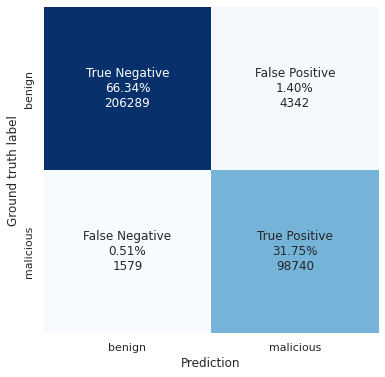

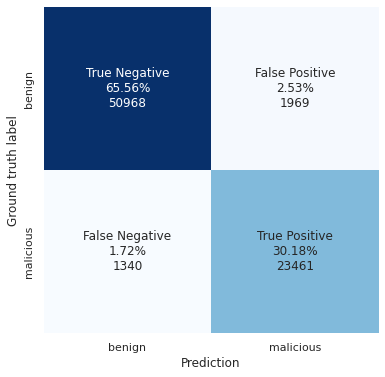

In [5]:
print("Training set")
print_scores(y_true, y_pred)
draw_confusion_matrix(y_true, y_pred, counts=True)
print("Validation set")
print_scores(yval_true, yval_pred)
draw_confusion_matrix(yval_true, yval_pred, counts=True)

# Loss plots

In [7]:
def get_content(pattern, path="."):
    files = os.listdir(path)
    matches = [x for x in files if pattern in x]
    print(f"Found {len(matches)} matches: {matches}")
    name = matches[0]
    if name.endswith("npy"):
        return np.load(path+"/"+name)
    elif name.endswith("pickle"):
        with open(path+"/"+name, "rb") as f:
            return pickle.load(f)

def plot_lists(lists, legend=[], 
                legend_title="",
                figsize=(14,6), 
                subplots=(1,1),
                ax=None,
                ):
    if not ax:
        _, ax = plt.subplots(*subplots, figsize=figsize)
    [ax.plot(x) for x in lists]
    ax.legend(legend, title=legend_title)
    return ax


In [38]:
train_loss = {}
val_loss = {}
train_metrics = {}
val_metrics = {}
duration = {}


prefix_dropout_nobn = "ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128"
val_loss["dropout_nobn"] = get_content(f"{prefix_dropout_nobn}-val_losses")
train_loss["dropout_nobn"] = get_content(f"{prefix_dropout_nobn}-train_losses")
val_metrics["dropout_nobn"] = get_content(f"{prefix_dropout_nobn}-val_metrics")
train_metrics["dropout_nobn"] = get_content(f"{prefix_dropout_nobn}-train_metrics")
duration["dropout_nobn"] = get_content(f"{prefix_dropout_nobn}-duration")

# cropping for first 50 epochs
prefix_dropout_bn = "ep100-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128"
val_loss["dropout_bn"] = get_content(f"{prefix_dropout_bn}-val_losses")[:len(val_loss["dropout_nobn"])]
train_loss["dropout_bn"] = get_content(f"{prefix_dropout_bn}-train_losses")[:len(train_loss["dropout_nobn"])]
val_metrics["dropout_bn"] = get_content(f"{prefix_dropout_bn}-val_metrics")[:len(val_metrics["dropout_nobn"])]
train_metrics["dropout_bn"] = get_content(f"{prefix_dropout_bn}-train_metrics")[:len(train_metrics["dropout_nobn"])]
duration["dropout_bn"] = get_content(f"{prefix_dropout_bn}-duration")[:len(duration["dropout_nobn"])]

weigt_decay_001 = "ep50-optim_adamw-lr0.001-l2reg0.01-dr0.0_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128"
val_loss["weigt_decay_001"] = get_content(f"{weigt_decay_001}-val_losses")
train_loss["weigt_decay_001"] = get_content(f"{weigt_decay_001}-train_losses")
val_metrics["weigt_decay_001"] = get_content(f"{weigt_decay_001}-val_metrics")
train_metrics["weigt_decay_001"] = get_content(f"{weigt_decay_001}-train_metrics")
duration["weigt_decay_001"] = get_content(f"{weigt_decay_001}-duration")

weigt_decay_01 = "ep49-optim_adamw-lr0.001-l2reg0.1-dr0.0_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128"
val_loss["weigt_decay_01"] = get_content(f"{weigt_decay_01}-val_losses")
train_loss["weigt_decay_01"] = get_content(f"{weigt_decay_01}-train_losses")
val_metrics["weigt_decay_01"] = get_content(f"{weigt_decay_01}-val_metrics")
train_metrics["weigt_decay_01"] = get_content(f"{weigt_decay_01}-train_metrics")
duration["weigt_decay_01"] = get_content(f"{weigt_decay_01}-duration")

Found 1 matches: ['ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128-val_losses.pickle']
Found 1 matches: ['ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128-train_losses.pickle']
Found 1 matches: ['ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128-val_metrics.pickle.npy']
Found 1 matches: ['ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128-train_metrics.pickle.npy']
Found 1 matches: ['ep50-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_False-ffnn256_128-duration.pickle']
Found 1 matches: ['ep100-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128-val_losses.pickle']
Found 1 matches: ['ep100-optim_adam-lr0.001-l2reg0-dr0.5_arr-ed64-kb150-pl150_model-conv128-bn_cFalse_f_True-ffnn256_128-train_losses.pickle']

<AxesSubplot:>

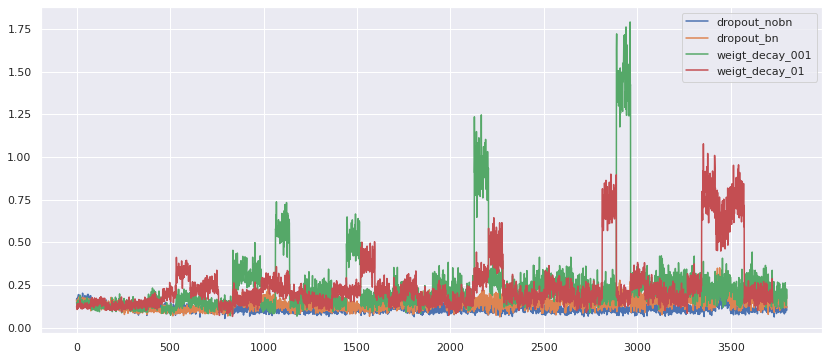

In [40]:
plot_lists(list(val_loss.values()), legend=list(val_loss.keys()))

<AxesSubplot:>

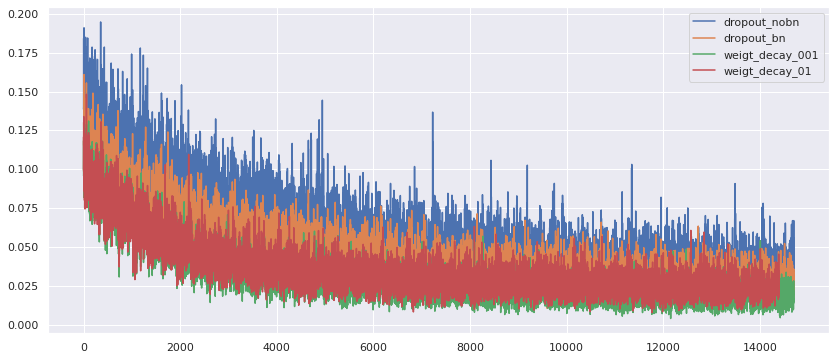

In [41]:
plot_lists([x[500:] for x in train_loss.values()], legend=list(train_loss.keys()))

In [ ]:
plot_lists(val_metrics)

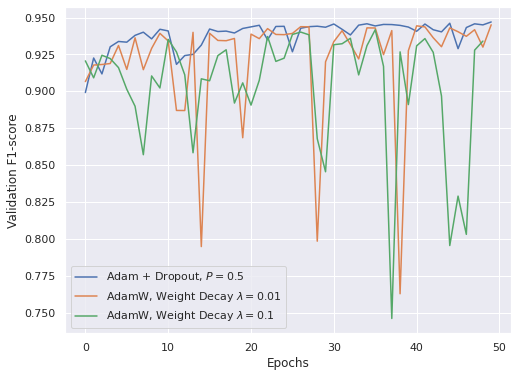

In [64]:
ax = plot_lists([x[:,1] for x in val_metrics.values()][1:], 
                figsize=(8,6),
                #legend=list(val_metrics.keys())[1:],
                legend=["Adam + Dropout, $P=0.5$", 
                        "AdamW, Weight Decay $\lambda=0.01$",
                        "AdamW, Weight Decay $\lambda=0.1$"])
_ = ax.set_ylabel("Validation F1-score")
_ = ax.set_xlabel("Epochs")

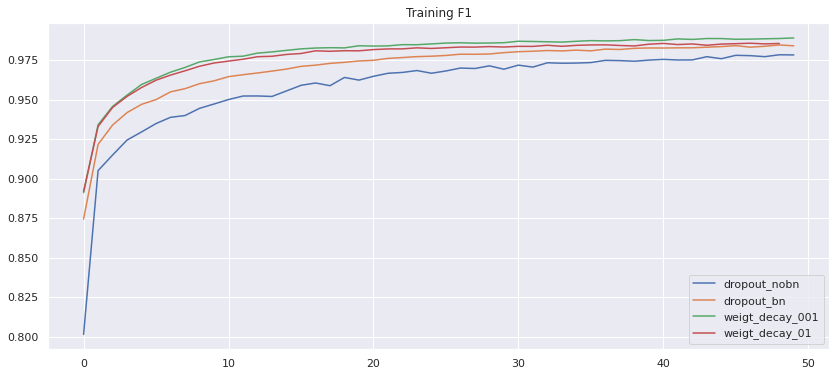

In [54]:
ax = plot_lists([x[:,1] for x in train_metrics.values()], legend=train_metrics.keys())
_ = ax.set_title("Training F1")